# TrainBN

In [1]:
using AutomotiveDrivingModels
using DynamicBayesianNetworkBehaviors

  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:7
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:9
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21


## Parameters

In [2]:
include(Pkg.dir("AutomotiveDrivingModels", "scripts", "extract_params.jl"))
nothing

In [3]:
dset_filepath_modifier = "_following" # _freeflow, _following, _lanechange

"_following"

In [4]:
dset = JLD.load(joinpath(EVALUATION_DIR, "dataset2" * dset_filepath_modifier * ".jld"),
                "model_training_data")::ModelTrainingData2
runlogs_original = load_runlogs(dset)
streetnets = load_streetnets(runlogs_original)

fold = 1
cv_split_outer = get_fold_assignment_across_drives(dset, N_FOLDS)
cv_split_inner = drop_fold!(deepcopy(cv_split_outer), fold)
@assert(cv_split_inner.nfolds > 0)

ntraces = length(cv_split_outer.seg_assignment);

## Optimize Hyperparams

In [5]:
train_def = BehaviorTrainDefinition(
                                    BN_TrainParams(
                                        indicators=INDICATOR_SET2,
                                        preoptimize_target_bins=true,
                                        preoptimize_indicator_bins=true,
                                        optimize_structure=true,
                                        optimize_target_bins=false,
                                        optimize_parent_bins=false,
                                        ncandidate_bins=20,
                                    ),
                                    [
                                        BehaviorParameter(:max_parents, 3:7, 2),
                                        BehaviorParameter(:dirichlet_prior, [UniformPrior(), BDeuPrior(0.5), BDeuPrior(1.0), BDeuPrior(2.0), BDeuPrior(10.0)], 1),
                                    ])

preallocated_data = preallocate_learning_data(dset, train_def.trainparams)
print(train_def); sleep(0.1)

BehaviorTrainDefinition
BN Train Params
starting_structure
	lat: AutomotiveDrivingModels.Features.AbstractFeature[]
	lon: AutomotiveDrivingModels.Features.AbstractFeature[]
forced
	lat: AutomotiveDrivingModels.Features.AbstractFeature[]
	lon: AutomotiveDrivingModels.Features.AbstractFeature[]
targets
	lat: f_des_angle
	lon: f_accel
prior:           UniformPrior
verbosity:       0
ncandidate_bins: 20
max_parents:     6
nbins_lat:       7
nbins_lon:       7
preoptimize_target_bins:    true
preoptimize_indicator_bins: true
optimize_structure:         true
optimize_target_bins:       false
optimize_parent_bins:       false

hyperparams:
	max_parents:         [3, >4<, 5, 6, 7]
	dirichlet_prior:     [>UniformPrior<, BDeuPrior(0.50), BDeuPrior(1.00), BDeuPrior(2.00), BDeuPrior(10.00)]


In [6]:
# AutomotiveDrivingModels.optimize_hyperparams_cyclic_coordinate_ascent!(
#                     train_def, dset, preallocated_data, cv_split_inner)
# print(train_def); sleep(0.1)

## Train

In [7]:
BN = train(dset, preallocated_data, train_def.trainparams, fold, cv_split_outer, true);
print(BN)

DynamicBayesianNetworkBehavior
	DBNModel: 
DBNModel
	f_des_angle <- [:velFt,:accFt]
	f_accel <- [:accFs,:has_lane_left]
	ind_lat:          1
	ind_lon:          2
	symbol_lat:       f_des_angle
	symbol_lon:       f_accel
	ordering:         [6,5,4,3,2,1]
	subset_extractor: AutomotiveDrivingModels.FeaturesNew.

## Likelihood

In [18]:
arr_logl_train = Float64[]
arr_logl_test = Float64[]
for frameind in 1 : nrow(dset.dataframe)
    if trains_with_nona(BN)
        logl = calc_action_loglikelihood(BN, dset.dataframe_nona, frameind)
    else
        logl = calc_action_loglikelihood(BN, dset.dataframe, frameind)
    end
    
    if is_in_fold(fold, cv_split_outer.frame_assignment[frameind], true)
        push!(arr_logl_test, logl)
    else
        push!(arr_logl_train, logl)
    end
end

@printf("%10s  %10s  %10s  %10s\n", "min", "mean", "median", "max")
@printf("%10.4f  %10.4f  %10.4f  %10.4f\n", minimum(arr_logl_train), mean(arr_logl_train), median(arr_logl_train), maximum(arr_logl_train))
@printf("%10.4f  %10.4f  %10.4f  %10.4f\n", minimum(arr_logl_test), mean(arr_logl_test), median(arr_logl_test), maximum(arr_logl_test))

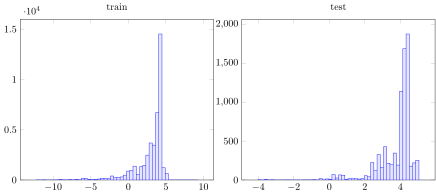

In [15]:
using PGFPlots
g = GroupPlot(2,1)
push!(g, Axis(Plots.Histogram(arr_logl_train, bins=50), ymin=0, title="train"))
push!(g, Axis(Plots.Histogram(arr_logl_test, bins=50), ymin=0, title="test"))
g

## Why is BN turning off-course?

In [16]:
include(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_cairo_utils.jl"))
include(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_dbn_cairo_utils.jl"))

Interact.Slider{Int64}(Signal{Int64}(760, nactions=0),"frame",760,1:1519)

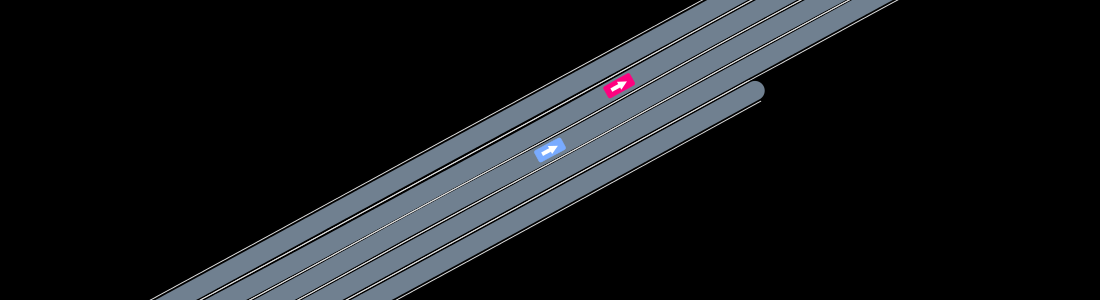

In [17]:
runlog = runlogs_original[1]
sn = streetnets[runlog.header.map_name]
plot_manipulable_runlog(runlog, sn)

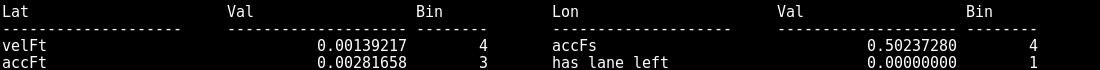

In [12]:
frame = 1311
plot_dbn_indicators(runlog, sn, BN, id2colset(runlog, RunLogs.ID_EGO, frame), frame)

In [13]:
plot_counts_over_conditioned_bin(runlog, sn, BN, id2colset(runlog, RunLogs.ID_EGO, frame), frame)

### Test BN Sampling

In [47]:
function select_action(
    behavior::DynamicBayesianNetworkBehavior,
    runlog::RunLog,
    sn::StreetNetwork,
    colset::UInt,
    frame::Int
    )

    model = behavior.model
    symbol_lat = behavior.symbol_lat
    symbol_lon = behavior.symbol_lon
    extractor = behavior.extractor
    action_clamper = behavior.action_clamper
    
    println("symbol_lat: ", symbol_lat)
    println("symbol_lon: ", symbol_lon)

    simparams_lat = behavior.simparams_lat
    simparams_lon = behavior.simparams_lon
    samplemethod_lat = simparams_lat.sampling_scheme
    samplemethod_lon = simparams_lon.sampling_scheme
    
    println("samplemethod_lat: ", samplemethod_lat)
    println("samplemethod_lon: ", samplemethod_lon)

    bmap_lat = model.discretizers[behavior.ind_lat_in_discretizers]
    bmap_lon = model.discretizers[behavior.ind_lon_in_discretizers]
    
    println("bmap_lat: ", map(v->@sprintf("%8.4f", v), bmap_lat.binedges))
    println("bmap_lon: ", map(v->@sprintf("%8.4f", v), bmap_lon.binedges))

    observations = behavior.observations
    assignment = behavior.assignment

    FeaturesNew.observe!(extractor, runlog, sn, colset, frame)
    DynamicBayesianNetworkBehaviors._copy_extracted_into_obs!(behavior)
    DynamicBayesianNetworkBehaviors.encode!(assignment, model, observations)
    
    println("extractor: ", map(f->symbol(f), extractor.indicators))
    println("observations: ", observations)
    println("assignment: ", assignment)
    
    bincounts = get_bin_counts(model)
    index_lat = indexof(get_target_lat(model), model)
    index_lon = indexof(get_target_lon(model), model)
    counts_lat = get_counts_for_assignment(model, index_lat, assignment, bincounts)
    counts_lon = get_counts_for_assignment(model, index_lon, assignment, bincounts)
    
    println(@sprintf("counts lat: %s", string(round(Int, counts_lat))))
    println(@sprintf("counts lon: %s", string(round(Int, counts_lon))))

    
    println("pvec lat: ", map(v->@sprintf("%7.4f", v), BayesNets.probvec(BayesNets.cpd(model.BN, symbol_lat), assignment)))
    println("pvec lon: ", map(v->@sprintf("%7.4f", v), BayesNets.probvec(BayesNets.cpd(model.BN, symbol_lon), assignment)))
    
    
#     sampled_counts_lat = zeros(Int, length(counts_lat))
#     sampled_counts_lon = zeros(Int, length(counts_lon))
#     for i in 1 : 100000
#         assignment[symbol_lat] = -1
#         assignment[symbol_lon] = -1
#         sample_unset!(model, assignment, behavior.ordering)
#         bin_lat = assignment[symbol_lat]
#         bin_lon = assignment[symbol_lon]
#         sampled_counts_lat[bin_lat] += 1
#         sampled_counts_lon[bin_lon] += 1
#     end
    
#     println("smpl lat: ", sampled_counts_lat)
#     println("smpl lon: ", sampled_counts_lon)
#     println("smpl lat: ", map(v->@sprintf("%7.4f", v), sampled_counts_lat/sum(sampled_counts_lat)))
#     println("smpl lon: ", map(v->@sprintf("%7.4f", v), sampled_counts_lon/sum(sampled_counts_lon)))
    
    assignment[symbol_lat] = -1
    assignment[symbol_lon] = -1
    sample_unset!(model, assignment, behavior.ordering)
    
    println("post-sample: ", assignment) # why was velFt changed?

    bin_lat = assignment[symbol_lat]
    bin_lon = assignment[symbol_lon]
    
    println("bin_lat: ", bin_lat)
    println("bin_lon: ", bin_lon)

    action_clamper.x[1] = Discretizers.decode(bmap_lat, bin_lat, samplemethod_lat)
    action_clamper.x[2] = Discretizers.decode(bmap_lon, bin_lon, samplemethod_lon)
    FeaturesNew.process!(behavior.action_clamper)
    
    @printf("range lat: %10.6f  %10.6f\n", extrema(bmap_lat, bin_lat)...)
    @printf("range lon: %10.6f  %10.6f\n", extrema(bmap_lon, bin_lon)...)
    
    action_lat = action_clamper.x[1]
    action_lon = action_clamper.x[2]
    
    @printf("action lat: %10.6f\n", action_lat)
    @printf("action lon: %10.6f\n", action_lon)
    sleep(0.1)

    (action_lat, action_lon)
end

select_action(BN, runlog, sn, id2colset(runlog, RunLogs.ID_EGO, frame), frame)

symbol_lat: f_des_angle
symbol_lon: f_accel
samplemethod_lat: Discretizers.SampleUniform()
samplemethod_lon: Discretizers.SampleUniform()
bmap_lat: ASCIIString[" -0.5586"," -0.0370"," -0.0291"," -0.0079"," -0.0079","  0.0105","  0.0381","  0.4380"]
bmap_lon: ASCIIString[" -3.3573"," -0.8106"," -0.4948"," -0.3563","  0.2235","  0.5835","  0.9481","  3.3280"]
extractor: [:velFt,:accFs,:accFt,:has_lane_left]
observations: Dict(:has_lane_left=>1.0,:velFt=>-0.533478592016757,:accFt=>-0.3057350684724099,:accFs=>0.31812601240405447)
assignment: Dict(:has_lane_left=>2,:velFt=>2,:accFt=>3,:f_des_angle=>5,:accFs=>4,:f_accel=>4)
counts lat: [0,5,108,0,55,0,0]
counts lon: [0,109,252,766,0,0,0]
pvec lat: ASCIIString[" 0.0057"," 0.0343"," 0.6229"," 0.0057"," 0.3200"," 0.0057"," 0.0057"]
pvec lon: ASCIIString[" 0.0009"," 0.0970"," 0.2231"," 0.6764"," 0.0009"," 0.0009"," 0.0009"]
post-sample: Dict(:has_lane_left=>2,:velFt=>2,:accFt=>3,:f_des_angle=>5,:accFs=>4,:f_accel=>2)
bin_lat: 5
bin_lon: 2
range 

(0.002212541753730788,-0.6927289584898777)

In [ ]:
# observations: Dict(:has_lane_left=>1.0,:velFt=>-0.533478592016757,:accFt=>-0.3057350684724099,:accFs=>0.31812601240405447)
# assignment: Dict(:has_lane_left=>2,:velFt=>2,:accFt=>3,:f_des_angle=>3,:accFs=>4,:f_accel=>3)

Interact.Slider{Int64}(Signal{Int64}(2178, nactions=0),"frame",2178,2118:2238)

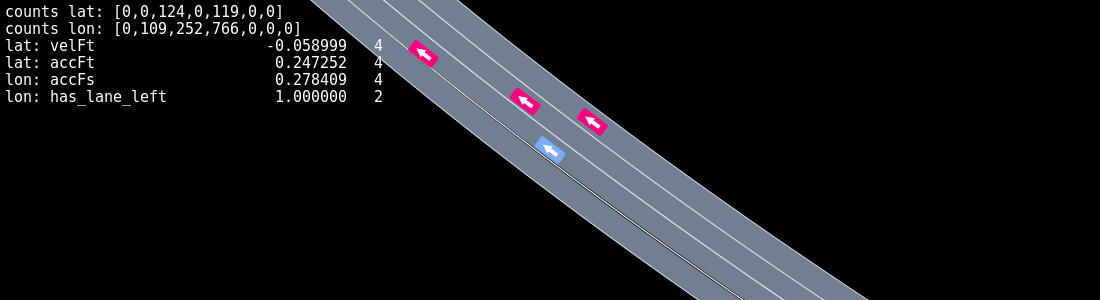

In [19]:
runlogseg = dset.runlog_segments[104]
runlog = runlogs_original[runlogseg.runlog_id]
sn = streetnets[runlog.header.map_name]

seg_duration = runlogseg.frame_end - runlogseg.frame_start
where_to_start_copying_from_original_runlog = max(1, runlogseg.frame_start - DEFAULT_TRACE_HISTORY)
where_to_start_simulating_from_runlog_sim = runlogseg.frame_start - where_to_start_copying_from_original_runlog + 1
where_to_end_simulating_from_runlog_sim = where_to_start_simulating_from_runlog_sim + seg_duration

runlog_sim = deepcopy(runlog, where_to_start_copying_from_original_runlog, runlogseg.frame_end)
plot_manipulable_runlog(runlog, sn, frames=where_to_start_copying_from_original_runlog:runlogseg.frame_end, overlays=Overlay[BNCountsOverlay(BN)])
# roll(
#     reel_runlog(runlog, sn, runlogseg.carid, frames=where_to_start_copying_from_original_runlog:runlogseg.frame_end),
#     fps=40)

In [42]:
simulate!(runlog_sim, sn, BN, runlogseg.carid, 
          where_to_start_simulating_from_runlog_sim, where_to_end_simulating_from_runlog_sim);

Interact.Slider{Int64}(Signal{Int64}(61, nactions=0),"frame",61,1:121)

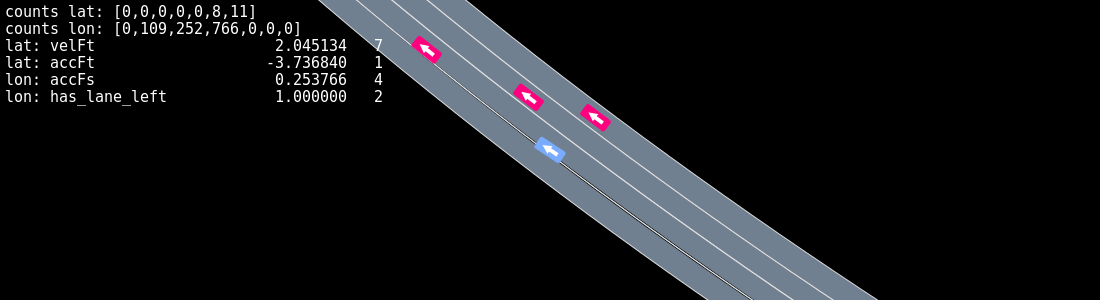

In [43]:
plot_manipulable_runlog(runlog_sim, sn, overlays=Overlay[BNCountsOverlay(BN)])
# roll(reel_runlog(runlog_sim, sn, runlogseg.carid, overlays=Overlay[BNCountsOverlay(BN)]), fps=40)

In [18]:
println("binedges lat: ", map(e->parse(Float64, @sprintf("%.3f",e)), BN.model.discretizers[BN.ind_lat].binedges))
println("binedges lon: ", map(e->parse(Float64, @sprintf("%.3f",e)), BN.model.discretizers[BN.ind_lon].binedges))
println("symbol lat: ", BN.symbol_lat)
println("symbol lon: ", BN.symbol_lon)

binedges lat: 